## 00 — Introduction to Machine Learning

This notebook introduces the **core ideas of machine learning** using a very simple
regression example. The goal is *not* to train a powerful model, but to understand:

- What is ML?
- What is a model?
- What is a **loss function**?
- How is all of this related to **statistics and noise**?

We will work with a tiny synthetic dataset:
- inputs \(x\)
- noisy observations \(y\)

and we will fit a simple linear model $f_\theta(x) = a x + b$ using **mean squared error** (MSE).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Set a seed for reproducibility
rng = np.random.default_rng(0)

#Make plots a bit nicer
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

## 1. Data, models and uncertainty

In physics, if we repeat the **same measurement** many times, we get **different values**.

Examples:
- signal in a detector with electronic noise,
- repeated measurements of a flux,
- energy reconstructed from a shower.

We describe this variability by treating measurements as **random variables**.

A **statistical model** is then a statement of the form:

> *"If the true parameter is $\theta$, then the data are distributed according to some probability distribution $p(x \mid \theta)$."*

For example, if we measure a quantity with Gaussian noise:

$x \sim {N}(\mu, \sigma^2),$

then $\theta = (\mu, \sigma)$ describes the model.

In **machine learning**, we usually:
- observe many pairs of data $(x_i, y_i)$,
- choose a flexible model $f_\theta(x)$,
- and adjust $\theta$ to fit the data well.

To see this concretely, let's build a tiny synthetic dataset.


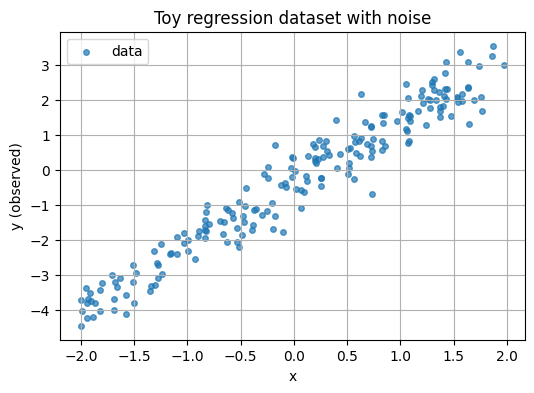

In [6]:
#Number of data points
N = 200

#Input values x sampled uniformly in a range
x = rng.uniform(-2, 2, size=N)

#True underlying relationship (unknown to the algorithm)
true_a = 1.8
true_b = -0.4

#Gaussian noise (experimental uncertainty)
sigma_noise = 0.5
noise = rng.normal(loc=0.0, scale=sigma_noise, size=N)

#Observed data y
y = true_a * x + true_b + noise

#Plot the data
plt.scatter(x, y, s=16, alpha=0.7, label="data")
plt.xlabel("x")
plt.ylabel("y (observed)")
plt.title("Toy regression dataset (with noise)")
plt.legend()
plt.show()

## 2. Model, parameters and loss

We will try to learn a simple **linear model**:

$f_\theta(x) = a x + b$

where the parameters are:
- a: slope
- b: intercept

From the model's point of view:
- inputs: $x$
- predictions: $\hat{y} = f_\theta(x)$
- true outputs (labels): $y$

To measure how good or bad a particular choice of $\theta = (a, b)$ is,
we use a **loss function**.

A very common choice in regression is the **mean squared error (MSE)**:

$\text{MSE}(\theta) = \frac{1}{N} \sum_{i=1}^N (y_i - f_\theta(x_i))^2.$


Machine learning training = **find parameters $\theta$ that minimize the loss**.

Let's implement this in code and visualize how the loss changes as we vary a and b.


In [7]:
def model(x, a, b):
    """Linear model: y_hat = a x + b"""
    return a * x + b

def mse_loss(a, b, x, y):
    """Mean squared error for given parameters a, b."""
    y_hat = model(x, a, b)
    return np.mean((y - y_hat) ** 2)

#Check the loss at the true parameters (we expect it to be "reasonably small")
loss_true = mse_loss(true_a, true_b, x, y)
loss_true


np.float64(0.2392665519330466)

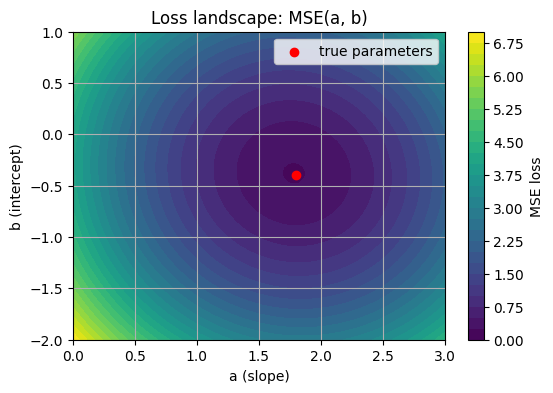

In [8]:
#Grid over slope a and intercept b
a_vals = np.linspace(0.0, 3.0, 60)
b_vals = np.linspace(-2.0, 1.0, 60)

A, B = np.meshgrid(a_vals, b_vals)
L = np.zeros_like(A)

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        L[i, j] = mse_loss(A[i, j], B[i, j], x, y)

#Contour plot of the loss
plt.contourf(A, B, L, levels=30)
plt.colorbar(label="MSE loss")
plt.scatter([true_a], [true_b], color="red", label="true parameters")
plt.xlabel("a (slope)")
plt.ylabel("b (intercept)")
plt.title("Loss landscape: MSE(a, b)")
plt.legend()
plt.show()


## Fit the model with `scikit-learn`

In [9]:
from sklearn.linear_model import LinearRegression

#Reshape x into a 2D array as required by scikit-learn
X = x.reshape(-1, 1)

linreg = LinearRegression()
linreg.fit(X, y)

a_hat = linreg.coef_[0]
b_hat = linreg.intercept_

print(f"Estimated parameters: a_hat = {a_hat:.3f}, b_hat = {b_hat:.3f}")
print(f"True parameters:      a_true = {true_a:.3f}, b_true = {true_b:.3f}")

#Compute MSE for the fitted model
y_hat = linreg.predict(X)
mse_hat = np.mean((y - y_hat) ** 2)
print(f"MSE of fitted model: {mse_hat:.3f}")


Estimated parameters: a_hat = 1.782, b_hat = -0.377
True parameters:      a_true = 1.800, b_true = -0.400
MSE of fitted model: 0.238


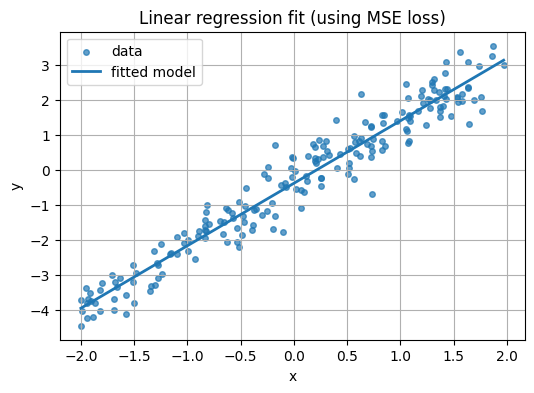

In [10]:
#Sort by x for a nicer line plot
order = np.argsort(x)
x_sorted = x[order]
y_sorted = y[order]
y_fit_sorted = y_hat[order]

plt.scatter(x, y, s=16, alpha=0.7, label="data")
plt.plot(x_sorted, y_fit_sorted, linewidth=2.0, label="fitted model")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear regression fit (using MSE loss)")
plt.legend()
plt.show()


## 3. Connecting loss to likelihood (statistical view)

So far we have:
- defined a model $f_\theta(x) = a x + b$,
- defined a loss (MSE),
- found $\theta$ that **minimizes** this loss.

Now we connect this to **statistics**.

Assume that, for each data point,
the measurement noise is **Gaussian**:

$y_i = f_\theta(x_i) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2).$

Then the probability (density) of observing $y_i$ given $x_i$ and $\theta$ is:

$p(y_i \mid x_i, \theta)
= \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left[-\frac{(y_i - f_\theta(x_i))^2}{2\sigma^2} \right].$

If the data points are independent, the **likelihood** of the whole dataset is:

$\mathcal{L}(\theta)
= \prod_{i=1}^N p(y_i \mid x_i, \theta).$

The **log-likelihood** is:

$\log \mathcal{L}(\theta)
= -\frac{1}{2\sigma^2} \sum_{i=1}^N (y_i - f_\theta(x_i))^2 - \frac{N}{2} \log(2\pi \sigma^2).$

The second term does **not** depend on $\theta$.  
So maximizing $log \mathcal{L}$ over $\theta$ is exactly the same as **minimizing**:

$\sum_{i=1}^N (y_i - f_\theta(x_i))^2,$

which is the **sum of squared errors**, i.e. (up to constants) the **MSE loss** we used.

**Conclusion:**

> Minimizing MSE is equivalent to **maximum likelihood estimation under Gaussian noise**.

This is the key conceptual bridge:

- The **loss function** in ML plays the role of **negative log-likelihood**.
- Choosing a loss implicitly means choosing an assumption about the **noise statistics**.
